In [1]:
import os
os.chdir("C:/Users/RAKESH MOURYA/Desktop/Bike_Sharing_Prediction/Bike_Sharing_Prediction")
%pwd

'C:\\Users\\RAKESH MOURYA\\Desktop\\Bike_Sharing_Prediction\\Bike_Sharing_Prediction'

In [8]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class EvaluationConfig:
    root_dir: Path
    test_data_path: Path
    model_path: Path
    metrics_path: Path



In [3]:
from bike_rental.constants import*
from bike_rental.utils.common import read_yaml, create_directories

In [12]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])
        
    def get_evaluation_config(self) -> EvaluationConfig:
        
        config = self.config.evaluation
    
        evaluation_config= EvaluationConfig(
            root_dir=Path(config.root_dir),
            test_data_path=Path(config.test_data_path),
            model_path=Path(config.model_path),
            metrics_path=Path(config.metrics_path)
        )
        create_directories([evaluation_config.root_dir])
        
        return evaluation_config

In [16]:
import pickle
import os
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from bike_rental import logger
import json
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


class Evaluation:
    def __init__(self, config: EvaluationConfig):
        self.config = config

    def evaluate(self):
        # Load model
        with open(self.config.model_path, "rb") as f:
            model_artifact = pickle.load(f)

        ols_model = model_artifact["model"]
        selected_features = model_artifact["features"]

        # Load test data
        df_test = pd.read_csv(self.config.test_data_path)

        y_test = df_test.pop("cnt")
        X_test = df_test[selected_features]

        # Add constant
        import statsmodels.api as sm
        X_test_const = sm.add_constant(X_test)

        # Predictions
        y_pred = ols_model.predict(X_test_const)

        # Metrics
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        
        
        results = {
            "r2_score": r2,
            "mse": mse,
            "mae": mae
        }
        
        # --- Visualization ---
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.xlabel("y_test")
        plt.ylabel("y_pred")
        plt.title("y_test vs y_pred")
        plt.show()
        
        # Save results
        with open(self.config.metrics_path, "w") as f:
            json.dump(results, f, indent=4)

        logger.info(f"Evaluation complete. Metrics stored at {self.config.metrics_path}")
        return results

    


[2025-09-14 16:28:57,194: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-09-14 16:28:57,194: INFO: common: yaml file: params.yaml loaded successfully]
[2025-09-14 16:28:57,194: INFO: common: created directory at: artifacts]
[2025-09-14 16:28:57,194: INFO: common: created directory at: artifacts\evaluation]


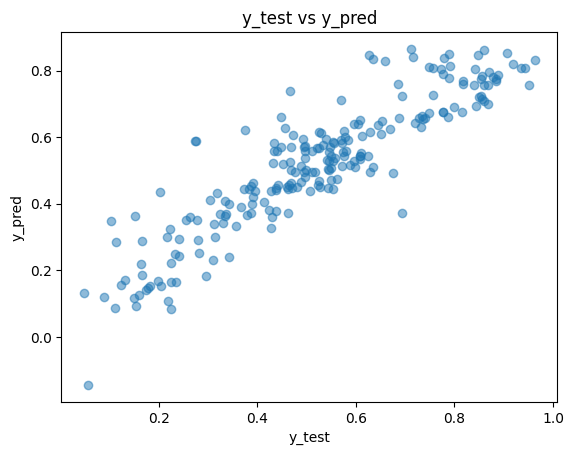

[2025-09-14 16:28:57,483: INFO: 2047683327: Evaluation complete. Metrics stored at artifacts\evaluation\metrics.json]
Evaluation Results: {'r2_score': 0.8088684155226322, 'mse': 0.009077949067796735, 'mae': 0.07293415605964117}


In [17]:
try:
    config = ConfigurationManager()
    eval_config = config.get_evaluation_config()
    evaluation = Evaluation(config=eval_config)
    results = evaluation.evaluate()
    print("Evaluation Results:", results)
except Exception as e:
    raise e
